<a href="https://colab.research.google.com/github/kiarashk76/DL4NLP-1st-Assignment/blob/master/1st_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#mounting the google drive for accessing the dataset

from google.colab import drive
drive.mount('/content/drive')

In [0]:
!cp '/content/drive/My Drive/Datasets/imdb-movie-reviews-dataset.zip' '/content/'
!unzip imdb-movie-reviews-dataset.zip

In [0]:
import numpy as np
import os

# listing training directories
train_pos = os.listdir('/content/aclImdb/train/pos')
for i in range(len(train_pos)):
  train_pos[i] = 'pos/' + train_pos[i] 
  
train_neg = os.listdir('/content/aclImdb/train/neg')
for i in range(len(train_neg)):
  train_neg[i] = 'neg/' + train_neg[i]

# listing test directories
test_pos = os.listdir('/content/aclImdb/test/pos')
for i in range(len(test_pos)):
  test_pos[i] = 'pos/' + test_pos[i] 
  
test_neg = os.listdir('/content/aclImdb/test/neg')
for i in range(len(test_neg)):
  test_neg[i] = 'neg/' + test_neg[i]
  
# extracting validation directories from training
np.random.shuffle(train_pos)
np.random.shuffle(train_neg)

val_pos = train_pos[0:2500]
val_neg = train_neg[0:2500]

del train_pos[0:2500]
del train_neg[0:2500]

# shuffling pos and neg trainings
X_train = train_pos +  train_neg 
y_train = [1] * len(train_pos) + [0] * len(train_neg)

np.random.seed(314)
np.random.shuffle(X_train) 
np.random.seed(314) 
np.random.shuffle(y_train)

# creating pos and neg validations
X_val = val_pos +  val_neg 
y_val = [1] * len(val_pos) + [0] * len(val_neg)

# creating pos and neg tests
X_test = test_pos +  test_neg 
y_test = [1] * len(test_pos) + [0] * len(test_neg)



In [0]:
def create_id2word(vocab):
  results = []
  for i in vocab:
    results.append(i[0])
  return results

def create_word2id(vocab):
  results = dict()
  for i in range(len(vocab)):
    results[vocab[i][0]] = i
  return results

In [0]:
vocab = dict()

# extract the 2000 most frequent words in our dataset
for address in X_train:
  file = open('/content/aclImdb/train/'+address,'r')
  txt = file.read().strip().lower()
  words = txt.split()
  for w in words:
    if w in vocab:
      vocab[w] += 1
    else:
      vocab[w] = 1


vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
vocab = vocab[0:2000]

id2word = create_id2word(vocab)
word2id = create_word2id(vocab)

In [0]:
# extract feature vectors for training

x_train = np.zeros( (len(X_train),2000), dtype=int)
i = 0
for address in X_train:
  file = open('/content/aclImdb/train/'+address,'r')
  txt = file.read().strip().lower()
  words = txt.split()
  for w in words:
    if w in word2id:
      x_train[i][word2id[w]] = 1
  i += 1
  
# extract feature vectors for validation
x_val = np.zeros( (len(X_val),2000), dtype=int)
i = 0
for address in X_val:
  file = open('/content/aclImdb/train/'+address,'r')
  txt = file.read().strip().lower()
  words = txt.split()
  for w in words:
    if w in word2id:
      x_val[i][word2id[w]] = 1
  i += 1
  
# extract feature vectors for test
x_test = np.zeros( (len(X_test),2000), dtype=int)
i = 0
for address in X_test:
  file = open('/content/aclImdb/test/'+address,'r')
  txt = file.read().strip().lower()
  words = txt.split()
  for w in words:
    if w in word2id:
      x_test[i][word2id[w]] = 1
  i += 1

In [0]:
import pickle


y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

# save the data into drive
pickle.dump([x_train, y_train, x_val, y_val, x_test, y_test], open("data.pkl", "wb")) 
pickle.dump([id2word, word2id],  open("aux.pkl", "wb"))

# load from the saved 
# x_train, y_train, x_val, y_val, x_test, y_test = pickle.load( open("data.pkl", "rb"))
# id2word, word2id = pickle.load( open("aux.pkl", "rb"))

In [0]:
import matplotlib.pyplot as plt


class logistic_regression():
  def __init__(self, batch_size = 20, learning_rate = 0.1, num_epochs = 300, threshhold = 0.5):
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.num_epochs = num_epochs
    self.loss_list = []
    self.threshhold = threshhold
    
  def set_training_data(self, X_train, y_train):
    self.X_train = X_train #(20000, 2000)
    self.y_train = y_train #(20000, )
    
  def set_validation_data(self, X_val, y_val):
    self.X_val = X_val #(5000, 2000)
    self.y_val = y_val #(5000, )
    
  def set_test_data(self, X_test, y_test):
    self.X_test = X_test #(25000,2000) 
    self.y_test = y_test #(25000)

  def init_weights(self):
    self.W = np.random.uniform(-0.5 ,0.5 , 2000) #(2000, )
    self.b = np.random.uniform(-0.5 ,0.5 , 1) #(1, )
    self.bestW = np.random.uniform(-0.5 ,0.5 , 2000)


  def train_model(self):
    self.init_weights()
    total_number_of_batches = int(self.X_train.shape[0] / self.batch_size)
    self.loss_list = []
    self.acc_train = []
    self.acc_val = []
    
    prev_accuracy = 0

    for i in range(self.num_epochs):
      print("epoch ",i,"-> ",end='')
      total_loss = 0
      for j in range(int(self.X_train.shape[0] / self.batch_size)):

        X = self.X_train[self.batch_size*j : self.batch_size* (j+1)] # (batch_size, 2000)
        y = self.y_train[self.batch_size*j : self.batch_size* (j+1)] # (batch_size, )

        # calculating probabilities of X
        h = (np.dot(X, self.W) + self.b) # (batch_size, )
        prob = 1 / (1 + np.exp(-h)) # (batch_size, )
        
        # avoiding runtime warning for log(0)
        for i in range(len(prob)):
          if prob[i] == 0:
            prob[i] = 10**(-10)
          if prob[i] == 1:
            prob[i] = 0.9999999999
      
        # calculating mean of loss for this batch
        loss = np.mean( (-y * np.log(prob))  -  ((1-y) * np.log(1-prob)) )
        # self.loss_list.append(loss)
        total_loss += loss

        # calculating gradient of loss for this batch (for weights and bias)
        gradW = np.dot ((prob - y), X)
        
        # updating weights
        self.W = self.W - self.learning_rate * gradW

      #  get prediction for all train and validation data
      predict_training = self.predict_label(self.X_train)
      predict_validation = self.predict_label(self.X_val)
      
      # calculating training accuracy
      counter = 0 
      for i in range(len(predict_training)):
        if predict_training[i] == self.y_train[i]:
          counter += 1
      train_acc = counter / len(predict_training)
      self.acc_train.append(train_acc)
      
      # calculating validation accuracy
      counter = 0 
      for i in range(len(predict_validation)):
        if predict_validation[i] == self.y_val[i]:
          counter += 1
      val_acc = counter / len(predict_validation)
      self.acc_val.append(val_acc)
                     
      # use this list to create a plot for loss 
      self.loss_list.append(total_loss/total_number_of_batches)  
      
      print("train acc:", train_acc, "validation acc:",val_acc, "loss:", total_loss/total_number_of_batches)
      # compare with previous weights with respect to validation accuracy to find best model
      if (prev_accuracy < val_acc):
        prev_accuracy = val_acc
        self.bestW = self.W
  
  def predict_label(self, x, bestW_flag = False):
    """make a prediction list of labels for x"""
    if (not bestW_flag):
      h = np.dot(x, self.W) + self.b
      prob = 1 / (1 + np.exp(-h))
      predict = np.empty_like(prob)
      for i in range(len(prob)):
        if prob[i] > self.threshhold :
          predict[i] = 1
        else:
          predict[i] = 0
    else:
      h = np.dot(x, self.bestW) + self.b
      prob = 1 / (1 + np.exp(-h))
      predict = np.empty_like(prob)
      for i in range(len(prob)):
        if prob[i] > self.threshhold :
          predict[i] = 1
        else:
          predict[i] = 0
      
    return predict
    
  def plot_loss(self):
    """plot the loss using loss list we gathered in training phase"""
    plt.subplot(2,1,1)
    plt.plot(self.loss_list)
    plt.xlabel("iterations")
    plt.ylabel("loss")
  
  def plot_accuracy(self):
    plt.subplot(2,1,2)
    plt.plot(self.acc_train, label= 'train accuracy')
    plt.plot(self.acc_val, label= 'validation accuracy')    
    plt.xlabel("iterations")
    plt.legend(loc='best')

    
  def test_best_model(self):
    predict_test = self.predict_label(self.X_test, bestW_flag = True)
    counter = 0 
    for i in range(len(predict_test)):
      if predict_test[i] == self.y_test[i]:
        counter += 1
    test_accuracy = counter / len(predict_test)
  
    return test_accuracy
  


epoch  0 -> train acc: 0.8312 validation acc: 0.805 loss: 1.5305812867776805
epoch  1 -> train acc: 0.84855 validation acc: 0.8172 loss: 0.9718467597379356
epoch  2 -> train acc: 0.8383 validation acc: 0.8032 loss: 0.9329752777494724
epoch  3 -> train acc: 0.85005 validation acc: 0.8144 loss: 0.9092767247062254
epoch  4 -> train acc: 0.85115 validation acc: 0.814 loss: 0.8783582385383749
epoch  5 -> train acc: 0.83425 validation acc: 0.8004 loss: 0.9072449570102002
epoch  6 -> train acc: 0.8553 validation acc: 0.8158 loss: 0.8904013869838501
epoch  7 -> train acc: 0.84475 validation acc: 0.8086 loss: 0.8926362654374177
epoch  8 -> train acc: 0.8657 validation acc: 0.8212 loss: 0.8959659862608909
epoch  9 -> train acc: 0.8416 validation acc: 0.8082 loss: 0.8769148797247277
epoch  10 -> train acc: 0.8613 validation acc: 0.8212 loss: 0.907335965614923
epoch  11 -> train acc: 0.84245 validation acc: 0.808 loss: 0.8800255947422656
epoch  12 -> train acc: 0.8574 validation acc: 0.8186 loss: 

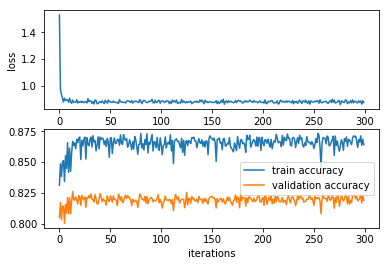

In [46]:
if __name__ == "__main__":
  lr = logistic_regression(batch_size = 20, learning_rate = 0.1, num_epochs = 300)
  lr.set_training_data(x_train, y_train)
  lr.set_validation_data(x_val, y_val)
  lr.set_test_data(x_test, y_test)
  lr.train_model()
  lr.plot_loss()
  lr.plot_accuracy()
  print("test accuracy for best model: ", lr.test_best_model())